In [13]:
import drjit as dr
import matplotlib.pyplot as plt
import mitsuba as mi

mi.set_variant("cuda_ad_spectral")

# Set these to false to debug values
# dr.set_flag(dr.JitFlag.VCallRecord, False)
# dr.set_flag(dr.JitFlag.LoopRecord, False)

In [14]:
import numpy as np

from enum import Enum
from typing import NamedTuple

from tmm_fast import coh_tmm

In [15]:
from drjit.cuda import (
    Float,
    UInt32,
    Int32,
    Array4f,
    Array3f,
    Array2f,
    TensorXf,
    Complex2f,
    Matrix2f,
    Matrix4f,
    Loop,
)

In [16]:
a = Complex2f((1,1))
b = Complex2f([(2,2), (1,2)])
lst = [a, a, a]
lst_tuples = []
for layer in lst:
    t = (layer.real[0], layer.imag[0])
    print(t)

(1.0, 1.0)
(1.0, 1.0)
(1.0, 1.0)


In [17]:
class Material(Enum):
    KERATIN = 1
    MELANIN_MEMBRANE = 2
    MELANIN_INTERNAL = 3
    AIR = 4

def cauchy(A, B, wavelengths):
    return A + B*dr.power(wavelengths, -2)

def melanin_imaginary(wavelengths):
    a_m = 0.56
    b_m = 270
    return a_m * dr.exp(-wavelengths / b_m)

def keratin_index(wavelengths):
    A_k = 1.532
    B_k = 5890
    return cauchy(A_k, B_k, wavelengths)

def melanin_index(wavelengths):
    A_m = 1.648
    B_m = 23700
    return cauchy(A_m, B_m, wavelengths)

def calc_keratin_layer(wavelengths):
    width = dr.width(wavelengths)
    f_k = 1
    n_k = keratin_index(wavelengths)
    f_m = dr.zeros(Complex2f, width)
    n_m = dr.zeros(Complex2f, width)
    k_m = dr.zeros(Complex2f, width)
    f_a = dr.zeros(Complex2f, width)
    n_a = dr.zeros(Complex2f, width)
    return f_k, n_k, f_m, n_m, k_m, f_a, n_a

def calc_melanin_layer(wavelengths):
    width = dr.width(wavelengths)
    f_k = dr.zeros(Complex2f, width)
    n_k = dr.zeros(Complex2f, width)
    f_m = dr.ones(Complex2f, width)
    n_m = melanin_index(wavelengths)
    k_m = melanin_imaginary(wavelengths)
    f_a = dr.zeros(Complex2f, width)
    n_a = dr.zeros(Complex2f, width)
    return f_k, n_k, f_m, n_m, k_m, f_a, n_a

def calc_melanosome_internal_layer_index(wavelengths):
    width = dr.width(wavelengths)
    f_k = 0.05 * dr.ones(Complex2f, width)
    n_k = keratin_index(wavelengths)
    f_m = 0.4 * dr.ones(Complex2f, width)
    n_m = melanin_index(wavelengths)
    k_m = melanin_imaginary(wavelengths)
    f_a = 0.55 * dr.ones(Complex2f, width)
    n_a = dr.ones(Complex2f, width)
    return f_k, n_k, f_m, n_m, k_m, f_a, n_a

def calc_refractive_index(f_k, n_k, f_m, n_m, k_m, f_a, n_a):
    n_eff = f_k * n_k + f_m * (n_m + k_m) + f_a * n_a

    return n_eff

def calc_layers(wavelengths):
    # Thicknesses in nm
    keratin_cortex_thickness = 5
    keratin_separation_thickness = 50
    melanosome_membrane_thickness = 30
    # Note: this can be changed to adjust periodicity
    melanosome_internal_thickness = 100
    top_melanosome_internal_thickness = 50

    air_layer_indices = (1, 0)
    keratin_layer_indices = calc_refractive_index(*calc_keratin_layer(wavelengths))
    melanosome_membrane_indices = calc_refractive_index(*calc_melanin_layer(wavelengths))
    melanosome_internal_indices = calc_refractive_index(*calc_melanosome_internal_layer_index(wavelengths))

    print(type(melanosome_membrane_indices))

    # # Init layers to first infinite air layer
    # layers = [[Material.AIR, np.inf]]

    # # Add keratin cortex layer
    # layers.append([Material.KERATIN, keratin_cortex_thickness])

    # # Add top melanosome layer
    # layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
    # layers.append([Material.MELANIN_INTERNAL, top_melanosome_internal_thickness])
    # layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # # Add the rest of the keratin separation and melanosome layers
    # melanosome_layers = 12
    # melanosome_layers -= 1  # Because of the top melanosome layer
    # for _ in range(melanosome_layers):
    #     layers.append([Material.KERATIN, keratin_separation_thickness])
    #     layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
    #     layers.append([Material.MELANIN_INTERNAL, melanosome_internal_thickness])
    #     layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # # Add keratin cortex layer
    # layers.append([Material.KERATIN, keratin_cortex_thickness])

    # # Add last infinite air layer
    # layers.append([Material.AIR, np.inf])

    n_list = [
        # Init layers to first infinite air layer
        air_layer_indices,
        # Add keratin cortex layer
        keratin_layer_indices,
        # Add top melanosome layer
        melanosome_membrane_indices,
        melanosome_internal_indices,
        melanosome_membrane_indices
    ]

    d_list = [
        # Init layers to first infinite air layer
        dr.inf,
        # Add keratin cortex layer
        keratin_cortex_thickness,
        # Add top melanosome layer
        melanosome_membrane_thickness,
        top_melanosome_internal_thickness,
        melanosome_membrane_thickness
    ]

    # Add the rest of the keratin separation and melanosome layers
    melanosome_layers = 12
    melanosome_layers -= 1  # Because of the top melanosome layer
    for _ in range(melanosome_layers):
        n_list.append(keratin_layer_indices)
        d_list.append(keratin_separation_thickness)

        n_list.append(melanosome_membrane_indices)
        d_list.append(melanosome_membrane_thickness)

        n_list.append(melanosome_internal_indices)
        d_list.append(melanosome_internal_thickness)

        n_list.append(melanosome_membrane_indices)
        d_list.append(melanosome_membrane_thickness)

    return Float(d_list), n_list


    # return layers[:, 1].astype(np.float32), layers_indices

In [18]:
def get_rows(z11, z12, z21, z22):
    return (
        Array4f(z11.real, -z11.imag, z12.real, -z12.imag),
        Array4f(z11.imag, z11.real, z12.imag, z12.real),
        Array4f(z21.real, -z21.imag, z22.real, -z22.imag),
        Array4f(z21.imag, z21.real, z22.imag, z22.real)
    )

def get_big_matrix(row0, row1, row2, row3):
    return dr.transpose(Matrix4f(row0, row1, row2, row3))

def get_00(m):
    return Complex2f(m[0, 0], m[1, 0])

def get_10(m):
    return Complex2f(m[2, 0], m[3, 0])

In [19]:
def is_forward_angle(n, theta):
    ncostheta = n * dr.cos(theta)

    m = dr.abs(ncostheta.imag) > 100 * dr.epsilon(Float)
    answer = dr.select(m, ncostheta.imag > 0, ncostheta.real > 0)

    return answer

def list_snell(n_list, th_0):
    n0_ = Complex2f(dr.slice(n_list, 0)) * dr.sin(th_0) / n_list

    angles = dr.asin(n0_)

    indices = UInt32([0, dr.width(n_list) - 1])
    n_result = dr.gather(Complex2f, n_list, indices)
    angles_result = dr.gather(Complex2f, angles, indices)

    # The first and last entry need to be the forward angle (the intermediate
    # layers don't matter, see https://arxiv.org/abs/1603.02720 Section 5)
    not_is_forward_angle = ~is_forward_angle(n_result, angles_result)
    angles_result = dr.select(not_is_forward_angle, dr.pi - angles_result, angles_result)
    dr.scatter(angles, angles_result, indices)

    return angles

def interface_t(polarization, n_i, n_f, th_i, th_f):
    if polarization == "s":
        return 2.0 * n_i * dr.cos(th_i) / (n_i * dr.cos(th_i) + n_f * dr.cos(th_f))
    elif polarization == "p":
        return 2.0 * n_i * dr.cos(th_i) / (n_f * dr.cos(th_i) + n_i * dr.cos(th_f))
    else:
        raise ValueError("Polarization must be 's' or 'p'")

def interface_r(polarization, n_i, n_f, th_i, th_f):
    if polarization == "s":
        return (n_i * dr.cos(th_i) - n_f * dr.cos(th_f)) / (n_i * dr.cos(th_i) + n_f * dr.cos(th_f))
    elif polarization == "p":
        return (n_f * dr.cos(th_i) - n_i * dr.cos(th_f)) / (n_f * dr.cos(th_i) + n_i * dr.cos(th_f))
    else:
        raise ValueError("Polarization must be 's' or 'p'")

def R_from_r(r):
    return dr.abs(r) ** 2

def coh_tmm_dr(pol, n_list, d_list, th_0, lam_vac):
    num_layers = dr.width(n_list)

    th_list = list_snell(n_list, th_0)

    kz_list = 2.0 * dr.pi * n_list * dr.cos(th_list) / lam_vac

    delta = kz_list * d_list

    # Get the first and last layer so they can be reset to their original values
    indices = UInt32([0, num_layers - 1])
    delta_result = dr.gather(Complex2f, delta, indices)

    # For a very opaque layer, reset delta to avoid divide-by-0 and similar
    # errors. The criterion imag(delta) > 35 corresponds to single-pass
    # transmission < 1e-30 --- small enough that the exact value doesn't
    # matter.
    delta = dr.select(delta.imag > 35, delta.real + Complex2f(35j), delta)
    # Reset the first and last layer to their original values
    dr.scatter(delta, delta_result, indices)

    # t_list[i,j] and r_list[i,j] are transmission and reflection amplitudes,
    # respectively, coming from i, going to j. Only need to calculate this when
    # j=i+1. (2D array is overkill but helps avoid confusion.)
    t_list = dr.zeros(Complex2f, num_layers * num_layers)
    r_list = dr.zeros(Complex2f, num_layers * num_layers)
    for i in range(num_layers - 1):
        n_list_i = Complex2f(dr.slice(n_list, i))
        n_list_j = Complex2f(dr.slice(n_list, i + 1))
        th_list_i = Complex2f(dr.slice(th_list, i))
        th_list_j = Complex2f(dr.slice(th_list, i + 1))

        t_list_result = interface_t(pol, n_list_i, n_list_j, th_list_i, th_list_j)
        r_list_result = interface_r(pol, n_list_i, n_list_j, th_list_i, th_list_j)

        index = UInt32([i * num_layers + i + 1])
        dr.scatter(t_list, t_list_result, index)
        dr.scatter(r_list, r_list_result, index)

    M_list = dr.zeros(Matrix4f, num_layers)
    for i in range(1, num_layers - 1):
        t = 1 / Complex2f(dr.slice(t_list, i * num_layers + i + 1))
        r = Complex2f(dr.slice(r_list, i * num_layers + i + 1))
        d = Complex2f(dr.slice(delta, i))

        T = get_big_matrix(*get_rows(t, 0, 0, t))

        A = get_big_matrix(
            *get_rows(dr.exp(Complex2f(0, -1) * d),
                      0,
                      0,
                      dr.exp(Complex2f(0, 1) * d))
        )

        B = get_big_matrix(*get_rows(1, r, r, 1))

        M = T @ (A @ B)
        dr.scatter(M_list, M, UInt32([i]))

    Mtilde = get_big_matrix(*get_rows(1, 0, 0, 1))
    for i in range(1, num_layers - 1):
        M = dr.transpose(Matrix4f(dr.slice(M_list, i)))
        Mtilde = Mtilde @ M

    t01 = 1 / Complex2f(dr.slice(t_list, 0 * num_layers + 1))
    T01 = get_big_matrix(*get_rows(t01, 0, 0, t01))
    Mtilde = get_big_matrix(*get_rows(1,
                                      Complex2f(dr.slice(r_list, 0 * num_layers + 1)),
                                      Complex2f(dr.slice(r_list, 0 * num_layers + 1)),
                                      1)) @ T01 @ Mtilde

    r = get_10(Mtilde) / get_00(Mtilde)

    R = R_from_r(r)

    return R


In [20]:
class MyBSDF(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)

        self.int_ior = mi.lookup_ior(props, "int_ior", "bk7")

        self.ext_ior = mi.lookup_ior(props, "ext_ior", "air")

        if self.int_ior < 0 or self.ext_ior < 0:
            raise ValueError("The interior and exterior indices of refraction must be positive!")

        self.eta = self.int_ior / self.ext_ior

        self.specular_reflectance = 1.0
        if props.has_property("specular_reflectance"):
            self.specular_reflectance: mi.Texture = props['specular_reflectance']
        self.specular_transmittance = 1.0
        if props.has_property("specular_transmittance"):
            self.specular_transmittance: mi.Texture = props['specular_transmittance']

        # Set the BSDF flags
        reflection_flags   = mi.BSDFFlags.DeltaReflection   | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide
        transmission_flags = mi.BSDFFlags.DeltaTransmission | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide | mi.BSDFFlags.NonSymmetric
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags

    def sample(self, ctx, si, sample1, sample2, active):
        # print(dr.value_t(si.wavelengths))
        layers = [calc_layers(wavelength) for wavelength in si.wavelengths]

        print(type(layers[0][0]))
        print(type(layers[0][1]))

        has_reflection = ctx.is_enabled(mi.BSDFFlags.DeltaReflection, 0)
        has_transmission = ctx.is_enabled(mi.BSDFFlags.DeltaTransmission, 1)

        # Evaluate the Frensel equations for unpolarized illumination
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)

        xs = dr.acos(cos_theta_i)

        r_i, cos_theta_t, eta_it, eta_ti = mi.fresnel(cos_theta_i, self.eta)
        t_i = 1.0 - r_i

        bs = mi.BSDFSample3f()
        selected_r = mi.Mask()
        if has_reflection and has_transmission:
            selected_r = (sample1 <= r_i) & active
            bs.pdf = dr.detach(dr.select(selected_r, r_i, t_i))
        else:
            if has_reflection or has_transmission:
                selected_r = has_reflection & active
                bs.pdf = 1.0
            else:
                return bs, 0.0

        selected_t = ~selected_r & active

        bs.sampled_component = dr.select(selected_r, mi.UInt32(0), mi.UInt32(1))
        bs.sampled_type = dr.select(selected_r, mi.UInt32(+mi.BSDFFlags.DeltaReflection),
                                                mi.UInt32(+mi.BSDFFlags.DeltaTransmission))

        bs.wo = dr.select(selected_r,
                          mi.reflect(si.wi),
                          mi.refract(si.wi, cos_theta_t, eta_ti))

        bs.eta = dr.select(selected_r, 1.0, eta_it)

        reflectance = mi.unpolarized_spectrum(1.0)
        transmittance = mi.unpolarized_spectrum(1.0)
        if self.specular_reflectance and self.specular_reflectance != 1.0:
            reflectance = self.specular_reflectance.eval(si, selected_r)
        if self.specular_transmittance and self.specular_reflectance != 1.0:
            transmittance = self.specular_transmittance.eval(si, selected_t)

        value_r = mi.Spectrum(0.0)
        value_t = mi.Spectrum(0.0)

        if has_reflection and has_transmission:
            value_r = mi.Spectrum(1.0)
            value_t = mi.Spectrum(t_i)

        # print("reflectance", dr.shape(reflectance))

        value_r *= reflectance
        value_t *= transmittance

        # print("value_r",full(ctor)

        value = dr.select(selected_r, value_r, value_t)

        value = dr.select(dr.sum(si.wavelengths) < 500, value * 0.5, value * 0.75)

        # value *= xs

        return bs, value

    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        return 0.0

    def eval_pdf(self, ctx, si, wo, active):
        return 0.0, 0.0

    def traverse(self, callback: mi.TraversalCallback):
        callback.put_parameter('eta', self.eta, +mi.ParamFlags.NonDifferentiable)
        if self.specular_reflectance:
            callback.put_object("specular_reflectance", self.specular_reflectance, +mi.ParamFlags.Differentiable)
        if self.specular_transmittance:
            callback.put_object("specular_transmittance", self.specular_transmittance, +mi.ParamFlags.Differentiable)

    def to_string(self):
        return (f'MyBSDF[\n'
                f'    eta={self.eta},\n'
                f']')

In [21]:
mi.register_bsdf("mybsdf", lambda props: MyBSDF(props))

In [22]:
scene = mi.load_file("matpreview/scene.xml")

In [23]:
img = mi.render(scene)

<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.Float'>
<class 'list'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.Float'>
<class 'list'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.Float'>
<class 'list'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.ad.Complex2f'>
<class 'drjit.cuda.Float'>
<class 'list'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


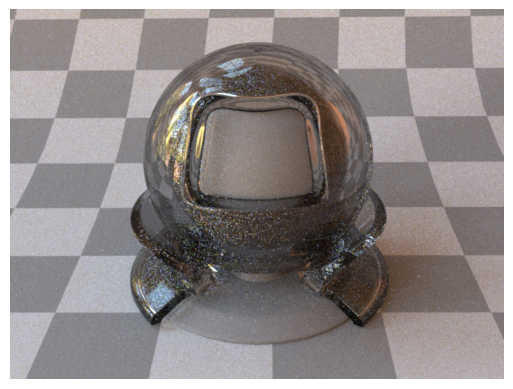

In [24]:
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)) # approximate sRGB tonemapping